## Sentiment Analysis


In [1]:
import datetime
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# read data files 
g = open('../pa2/reviews.txt','r') # What we know!
reviews_all = list(map(lambda x:x[:-1],g.readlines()))
g.close()
g = open('../pa2/labels.txt','r') # What we WANT to know!
sentiments_all = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

# load vocabulary
g = open('../pa2/vocab.txt','r')
vocab = [s.strip() for s in g.readlines()]

The data is a set of 25000 movie reviews, along with a `POSITIVE` or `NEGATIVE` sentiment label assigned to the review.

In [6]:
# split into training and test data
reviews_train,reviews_test = reviews_all[0:24000],reviews_all[24000:]
sentiments_train,sentiments_test = sentiments_all[0:24000],sentiments_all[24000:]

In [8]:
# maintain Counter objects to store positive, negative and total counts for
# all the words present in the positive, negative and total reviews.
positive_word_count = Counter()
negative_word_count = Counter()
total_counts = Counter()

# Instantiate Vocab as a <Key,None> Dict
g = open('../pa2/vocab.txt','r')

vocab_words_all = list(map(lambda x:x[:-1], g.readlines()))
vocab_dict = dict(zip(vocab_words_all, vocab_words_all))
selector = '[^A-Za-z]+'

for index, review in enumerate(reviews_train):
    raw_words = list(map(lambda word: re.sub(selector, '', word), review.split(' ')))
    words = list(filter(lambda word: word.isalpha(), review.split(' ')))
    if sentiments_train[index] == 'POSITIVE':
        positive_word_count.update(words)
    elif sentiments_train[index] == 'NEGATIVE':
        negative_word_count.update(words)
    else:
        pass

# Delete Words from Counters if not available in Vocabulary    
del_keys = []
for key, value in positive_word_count.items():
    if vocab_dict[str(key)]!=None:
        pass
    else:
        del_keys.append(positive_word_count[key])

del_keys = []
for key, value in positive_word_count.items():
    if vocab_dict[str(key)]!=None:
        pass
    else:
        del_keys.append(positive_word_count[key])

for i in del_keys:
    del negative_word_count[i]
    
total_counts = positive_word_count+negative_word_count

In [9]:
# maintain a Counter object to store positive to negative ratios 
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        try:
            pos_neg_ratios[term] = (positive_word_count[term]+1)/(negative_word_count[term]+1)
        except ZeroDivisionError:
            pos_neg_ratios[term] = 1

In [10]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

print("Pos-to-neg ratio for 'movie' = {}".format(pos_neg_ratios["movie"]))
print("Pos-to-neg ratio for 'titaic' = {}".format(pos_neg_ratios["titanic"]))

Pos-to-neg ratio for 'the' = 1.0618578344986418
Pos-to-neg ratio for 'amazing' = 4.019607843137255
Pos-to-neg ratio for 'terrible' = 0.17317612380250552
Pos-to-neg ratio for 'movie' = 0.7571196940090633
Pos-to-neg ratio for 'titaic' = 2.183333333333333


In [11]:
# take a log of the ratio
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)
pos_neg_ratios['bad']

-1.3777812959604037

(-4.269697449699962, 4.700480365792417)

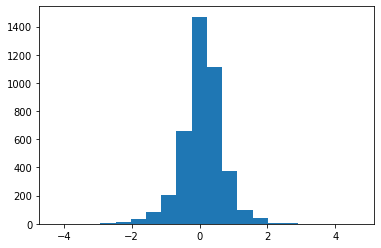

In [12]:
# visualize the distribution of the log-ratio scores
scores = np.array(list(pos_neg_ratios.values()))
vocab_selected = list(pos_neg_ratios.keys())
vocab_selected_1 = list(pos_neg_ratios.keys())

h = plt.hist(scores,bins=20)
min(scores), max(scores)

The above histogram should give you an idea about the distribution of the scores.

Notice how the scores are distributed around 0. A word with score 0 can be considered as `neutral`. 

In [13]:
# Print few words with neutral score
for ind in np.where(scores == 0)[0][0:5]:
    print(vocab_selected[ind])

print(len(scores))

realize
hands
extreme
beat
onto
4116


**APPROACH 1** A simple non-machine learning that only uses the log-ratios to determine if a review is positive or negative. This function will be applied to the test data to calculate the accuracy of the model. 

In [14]:
def nonml_classifier(review,pos_neg_ratios):
    '''
    Function that determines the sentiment for a given review.
    
    Inputs:
      review - A text containing a movie review
      pos_neg_ratios - A Counter object containing frequent words
                       and corresponding log positive-negative ratio
    Return:
      sentiment - 'NEGATIVE' or 'POSITIVE'
    '''
    selector = '[^A-Za-z]+'
    stop_words = set(stopwords.words('english'))
    words = list(map(lambda word: re.sub(selector, '', word), review.split(' ')))
    score = 0
    for word in words:
        # Threshold from analyzing words between in lower end of pos & neg words
        if pos_neg_ratios[word] >= 0.5 or pos_neg_ratios[word] <= -0.5 and word not in stop_words:
            score += pos_neg_ratios[word]
    return 'NEGATIVE' if score<0 else 'POSITIVE'

In [15]:
predictions_test = []
for r in reviews_test:
    l = nonml_classifier(r,pos_neg_ratios)
    predictions_test.append(l)
# calculate accuracy
correct = 0
for l,p in zip(sentiments_test,predictions_test):
    if l == p:
        correct = correct + 1
print('Accuracy of the model = {}'.format((correct/len(sentiments_test))))

Accuracy of the model = 0.811


**Approach 2** Implemented a neural network for sentiment classification. 



In [16]:
def create_input_vector(review,word2index):
    '''
    Function to count how many times each word is used in the given review,
    # and then store those counts at the appropriate indices inside x.
    '''
    vocab_size = len(word2index)
    x = np.zeros((1, vocab_size))
    for w in review.split(' '):
        if w in word2index.keys():
            x[0][word2index[w]] += 1
    return x

In [17]:
def find_ignore_words(pos_neg_ratios):
    '''
    Function to identify words to ignore from the vocabulary
    '''
    ignore_words = []
    for words, ratios in pos_neg_ratios.items():
        if (ratios <= 0.5) and (ratios >= -0.5):
            ignore_words.append(words)
    return ignore_words

In [18]:
# create a word2index mapping from word to an integer index
word2index, word2index_or = {}, {}
ignore_words = find_ignore_words(pos_neg_ratios)

vocab_original = vocab_selected_1
for i,word in enumerate(vocab_original):
    word2index_or[word] = i
vocab_size_or = (word2index_or)
        
vocab_selected = list(set(vocab_selected).difference(set(ignore_words)))
for i,word in enumerate(vocab_selected):
    if word not in ignore_words:
        word2index[word] = i
vocab_size = len(word2index)

#### Generate .hdf5 files from the processed data
Given that the data is moderately large sized, the `hdf5` file format provides a more efficient file representation for further processing. See [here](https://anaconda.org/anaconda/hdf5) for more details and installation instructions.

In [19]:
import h5py

In [20]:
'''# Without Ignore Words
word2index = word2index_or
vocab_size = len(vocab_size_or)
'''

# Run the script once to generate the file 
# delete the existing 'data1.hdf5' file before running it again to avoid error 
labels_train = np.zeros((len(sentiments_train), 2), dtype=int)
labels_test = np.zeros((len(sentiments_test), 2), dtype=int)

with h5py.File('data1.hdf5', 'w') as hf:
    hf.create_dataset('data_train', (labels_train.shape[0], vocab_size), np.int16)
    hf.create_dataset('data_test', (labels_test.shape[0], vocab_size), np.int16)
    
    # create training data
    for i,(r,l) in enumerate(zip(reviews_train, sentiments_train)):
        hf["data_train"][i] = create_input_vector(r,word2index)
        # one-hot encoding
        if l == 'NEGATIVE':
            labels_train[i, 0] = 1
        else:
            labels_train[i, 1] = 1
            
    # create test data
    for i,(r,l) in enumerate(zip(reviews_test, sentiments_test)):
        hf["data_test"][i] = create_input_vector(r,word2index)
        # one-hot encoding
        if l == 'NEGATIVE':
            labels_test[i, 0] = 1
        else:
            labels_test[i, 1] = 1


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.random.set_random_seed(10)

In [ ]:
# parameters of the network
learning_rate = 0.01
batch_size = 400
num_epochs = 50
n_input = vocab_size
n_classes = 2

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Define weights and biases in Tensorflow according to the parameters set above
n_hidden_1 = 10  # 1st layer number of neurons
n_hidden_2 = 8
n_hidden_3 = 5

weights = {
	'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
	'out2': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
}
biases = {
	'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
	'out2': tf.Variable(tf.random_normal([n_classes]))
}

def multilayer_perceptron(x):
    # define the layers of a single layer perceptron
    net_layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    net_layer_2 = tf.add(tf.matmul(net_layer_1, weights['h2']), biases['b2'])
    net_layer_3 = tf.add(tf.matmul(net_layer_2, weights['h3']), biases['b3'])
    out_layer = tf.nn.sigmoid(tf.matmul(net_layer_3, weights['out2']) + biases['out2'])
    return out_layer


In [23]:
logits = multilayer_perceptron(X)
diff = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
loss_op = tf.reduce_mean(diff)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
    
# Initializing the variables
init = tf.global_variables_initializer()

In [24]:
# for some macosx installations, conflicting copies of mpilib causes trouble with tensorflow.
# use the following two lines to resolve that issue
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [25]:
with tf.Session() as sess:
    start_time = time.time()
    sess.run(init)

    h = h5py.File('data1.hdf5', 'r')
    n1 = h.get('data_train') 
    n2 = h.get('data_test')

    # Training cycle
    total_batch_train = int(n1.shape[0] / batch_size)
    total_batch_test = int(n2.shape[0] / batch_size)

    for iter_num in range(num_epochs):
        # variables for train and test accuracies
        avg_acc_train = 0.
        avg_acc_test = 0.
        for i in range(total_batch_train):
            train_x = n1[(i) * batch_size: (i + 1) * batch_size, ...]
            train_y = labels_train[(i) * batch_size: (i + 1) * batch_size, :]
            _, c_train, _logits_train = sess.run([train_op, loss_op, logits], feed_dict={X: train_x, Y: train_y})#, options= run_options)

            _label_train = [np.argmax(i) for i in _logits_train]
            _label_train_y = [np.argmax(i) for i in train_y]
            _accuracy_train = np.mean(np.array(_label_train) == np.array(_label_train_y))
            avg_acc_train += _accuracy_train
        
        for j in range(total_batch_test):
            test_x = n2[(j) * batch_size: (j + 1) * batch_size, ...]
            test_y = labels_test[(j) * batch_size: (j + 1) * batch_size, :]

            c_test, _logits_test = sess.run([loss_op, logits], feed_dict={X: test_x, Y: test_y})
            _label_test = [np.argmax(i) for i in _logits_test]
            _label_test_y = [np.argmax(i) for i in test_y]
            _accuracy_test = np.mean(np.array(_label_test) == np.array(_label_test_y))
            avg_acc_test += _accuracy_test
        
        # print the train and test accuracies
        print("Train acc: %f, Test_acc: %f" % (avg_acc_train/total_batch_train, avg_acc_test/total_batch_test))
    
    duration = time.time() - start_time
    print('Time elapsed - {} seconds.'.format(duration))    

hf.close()
sess.close()

Train acc: 0.603542, Test_acc: 0.692500
Train acc: 0.755250, Test_acc: 0.761250
Train acc: 0.808958, Test_acc: 0.792500
Train acc: 0.831458, Test_acc: 0.816250
Train acc: 0.844000, Test_acc: 0.812500
Train acc: 0.856917, Test_acc: 0.816250
Train acc: 0.861917, Test_acc: 0.818750
Train acc: 0.867250, Test_acc: 0.821250
Train acc: 0.872500, Test_acc: 0.821250
Train acc: 0.873417, Test_acc: 0.823750
Train acc: 0.876000, Test_acc: 0.820000
Train acc: 0.877083, Test_acc: 0.832500
Train acc: 0.880208, Test_acc: 0.831250
Train acc: 0.880875, Test_acc: 0.818750
Train acc: 0.882333, Test_acc: 0.825000
Train acc: 0.884667, Test_acc: 0.825000
Train acc: 0.887208, Test_acc: 0.820000
Train acc: 0.887667, Test_acc: 0.817500
Train acc: 0.885792, Test_acc: 0.823750
Train acc: 0.889292, Test_acc: 0.827500
Train acc: 0.889917, Test_acc: 0.822500
Train acc: 0.890042, Test_acc: 0.833750
Train acc: 0.890833, Test_acc: 0.830000
Train acc: 0.890917, Test_acc: 0.823750
Train acc: 0.892792, Test_acc: 0.827500
